In [1]:
!pip install split-folders --quiet
!pip install torch torchvision transformers datasets --quiet
!pip install roboflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but 

In [2]:
!nvidia-smi

Mon Jul 22 09:02:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="f92r8UAteQo539m5sPi1")
project = rf.workspace("esd-krexe").project("drowsiness-detection-0mcjg")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drowsiness-detection-1 in folder:: 100%|██████████| 9131/9131 [00:04<00:00, 2053.22it/s]


In [4]:
DATA_DIR = '/content/Drowsiness-detection-1'

In [1]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

c:\anaconda3\envs\machine_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(image):
    return _train_transforms(image.convert("RGB"))

def val_transform(image):
    return _val_transforms(image.convert("RGB"))

In [7]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/train/', transform=train_transforms)
valid_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/valid/', transform=val_transform)
test_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/test/', transform=val_transform)

In [19]:
from transformers import ViTModel
import torch.nn as nn

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [18]:
EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

In [176]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

<All keys matched successfully>

In [49]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(valid_ds))
print("Detected Classes are: ", valid_ds.class_to_idx)

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

best_loss = float('inf')
best_model_state = None

patience = 5

# Train the model
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    for step, (x, y) in enumerate(train_loader):
        # Change input array into list with each batch being one element
        x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
        # Remove unnecessary dimension
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        x = torch.tensor(np.stack(x, axis=0))
        # Send to GPU if available
        x, y = x.to(device), y.to(device)
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)
        # Feed through model
        output, loss = model(b_x, None)
        # Calculate loss
        if loss is None:
            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if step % 50 == 0:
            # Get the next batch for testing purposes
            val = next(iter(val_loader))
            val_x = val[0]
            # Reshape and get feature matrices as needed
            val_x = np.split(np.squeeze(np.array(val_x)), BATCH_SIZE)
            for index, array in enumerate(val_x):
              val_x[index] = np.squeeze(array)
            val_x = torch.tensor(np.stack(val_x, axis=0))
            # Send to appropirate computing device
            val_x = val_x.to(device)
            val_y = val[1].to(device)
            # Get output (+ respective class) and compare to target
            val_output, loss = model(val_x, val_y)
            val_output = val_output.argmax(1)
            # Calculate Accuracy
            accuracy = (val_output == val_y).sum().item() / BATCH_SIZE
            if loss < best_loss:
                best_loss = loss
                best_model_state = model.state_dict()
                torch.save(best_model_state, 'best.pt')
                print(f'Best model saved with loss: {best_loss:.4f}')
                patience_counter = 0
            else:
                patience_counter += 1
            print(f'Epoch: {epoch} | Val Loss: {loss:.4f} | Val Accuracy: {accuracy:.2f}')
            if patience_counter >= patience:
              print(f'Early stopping triggered at epoch {epoch}.')
              break

print(f'Best loss achieved: {best_loss:.4f}')

Number of train samples:  6384
Number of test samples:  912
Detected Classes are:  {'Active Subjects': 0, 'Fatigue Subjects': 1}


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Best model saved with loss: 0.7025
Epoch: 0 | Test Loss: 0.7025 | Test Accuracy: 0.50
Best model saved with loss: 0.5344
Epoch: 0 | Test Loss: 0.5344 | Test Accuracy: 0.75
Best model saved with loss: 0.3209
Epoch: 0 | Test Loss: 0.3209 | Test Accuracy: 0.94
Best model saved with loss: 0.2504
Epoch: 0 | Test Loss: 0.2504 | Test Accuracy: 0.94
Best model saved with loss: 0.1000
Epoch: 0 | Test Loss: 0.1000 | Test Accuracy: 1.00
Epoch: 0 | Test Loss: 0.1427 | Test Accuracy: 1.00
Best model saved with loss: 0.0749
Epoch: 0 | Test Loss: 0.0749 | Test Accuracy: 1.00
Epoch: 0 | Test Loss: 0.3590 | Test Accuracy: 0.81


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Epoch: 1 | Test Loss: 0.1318 | Test Accuracy: 0.94
Epoch: 1 | Test Loss: 0.1295 | Test Accuracy: 1.00
Epoch: 1 | Test Loss: 0.1358 | Test Accuracy: 0.94
Best model saved with loss: 0.0611
Epoch: 1 | Test Loss: 0.0611 | Test Accuracy: 1.00
Epoch: 1 | Test Loss: 0.1215 | Test Accuracy: 0.94
Epoch: 1 | Test Loss: 0.1910 | Test Accuracy: 0.94
Epoch: 1 | Test Loss: 0.2765 | Test Accuracy: 0.81
Best model saved with loss: 0.0212
Epoch: 1 | Test Loss: 0.0212 | Test Accuracy: 1.00
Epoch: 2 | Test Loss: 0.2062 | Test Accuracy: 0.88
Epoch: 2 | Test Loss: 0.0983 | Test Accuracy: 1.00
Epoch: 2 | Test Loss: 0.1868 | Test Accuracy: 0.94
Epoch: 2 | Test Loss: 0.2214 | Test Accuracy: 0.94
Best model saved with loss: 0.0197
Epoch: 2 | Test Loss: 0.0197 | Test Accuracy: 1.00
Epoch: 2 | Test Loss: 0.1787 | Test Accuracy: 0.88
Epoch: 2 | Test Loss: 0.0964 | Test Accuracy: 0.94
Epoch: 2 | Test Loss: 0.1769 | Test Accuracy: 0.94
Best loss achieved: 0.0197


Test Loss: 0.1561 | Test Accuracy: 0.94 | F1 Score: 0.94


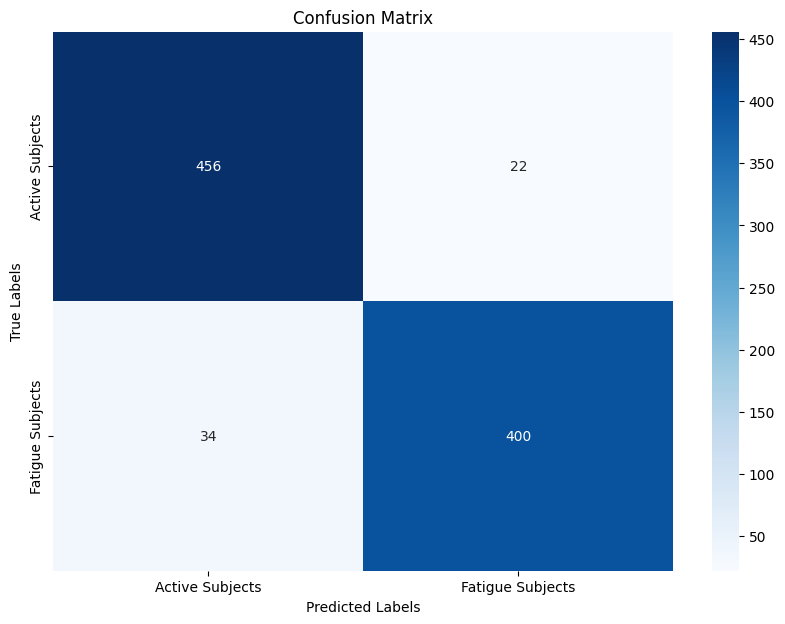

In [50]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.load_state_dict(torch.load('best.pt'))
model.to(device)
model.eval()

test_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
eval_loader = data.DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)

with torch.no_grad():
    for x, y in eval_loader:
        # Ensure x has the correct shape
        if len(x.shape) == 3:
            x = x.unsqueeze(0)  # Add batch dimension

        x = x.to(device)
        y = y.to(device)
        output, loss = model(x, y)
        test_loss += loss
        _, predicted = torch.max(output, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        # Collect predictions and true labels for metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Average loss and accuracy
test_loss /= len(eval_loader)
accuracy = correct / total
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f} | F1 Score: {f1:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()